## This jupyter notebook will be mainly used for Coursera Capstone project
### We will use supervised algorithm to predict the severity of an accident

In [1]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [2]:
print("Hello Capstone Project Course!")

Hello Capstone Project Course!


In [3]:
landingDir = "E:/coursera/capstoneDS/github/Coursera_Capstone/"

In [4]:
inputDF = pd.read_csv(landingDir+"/datasets/Data-Collisions.csv")

e:\pycharmprojects\myprojects\venv\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (33) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
len(inputDF)

194673

In [6]:
#finding if any column contains nan
nanColumns = inputDF.columns[inputDF.isna().any()].tolist()

### some columns like key, objectid etc are not important

In [7]:
#dropping some columns like codes, identifiers etc
inputDF.drop(columns=['X','Y','OBJECTID','INCKEY','COLDETKEY','REPORTNO','STATUS','INTKEY','EXCEPTRSNCODE','EXCEPTRSNDESC'
                      ,'SEVERITYCODE.1','SEVERITYDESC','INCDATE','SDOT_COLDESC','SDOTCOLNUM','ST_COLDESC','SEGLANEKEY',
                      'CROSSWALKKEY'],inplace=True)

In [8]:
#finding count of null values for columns
inputDF.isna().sum()

SEVERITYCODE           0
ADDRTYPE            1926
LOCATION            2677
COLLISIONTYPE       4904
PERSONCOUNT            0
PEDCOUNT               0
PEDCYLCOUNT            0
VEHCOUNT               0
INCDTTM                0
JUNCTIONTYPE        6329
SDOT_COLCODE           0
INATTENTIONIND    164868
UNDERINFL           4884
WEATHER             5081
ROADCOND            5012
LIGHTCOND           5170
PEDROWNOTGRNT     190006
SPEEDING          185340
ST_COLCODE            18
HITPARKEDCAR           0
dtype: int64

In [9]:
inputDF.dtypes

SEVERITYCODE       int64
ADDRTYPE          object
LOCATION          object
COLLISIONTYPE     object
PERSONCOUNT        int64
PEDCOUNT           int64
PEDCYLCOUNT        int64
VEHCOUNT           int64
INCDTTM           object
JUNCTIONTYPE      object
SDOT_COLCODE       int64
INATTENTIONIND    object
UNDERINFL         object
WEATHER           object
ROADCOND          object
LIGHTCOND         object
PEDROWNOTGRNT     object
SPEEDING          object
ST_COLCODE        object
HITPARKEDCAR      object
dtype: object

In [10]:
#its really difficult to replace the nan with some values. Let's try dropping them as it is less compared to the total rows
inputDF.dropna(subset = ["ADDRTYPE","LOCATION","COLLISIONTYPE","JUNCTIONTYPE","WEATHER","ROADCOND",
                                   "LIGHTCOND","ST_COLCODE"], inplace=True)

## replacing boolean to 1, 0 

In [12]:
#inattentionid is "y" or blank, let's replace y with 1 and blank with 0
inputDF["INATTENTIONIND"]=inputDF["INATTENTIONIND"].apply(lambda x : 1 if x=="Y" else 0)
inputDF["UNDERINFL"]=inputDF["UNDERINFL"].apply(lambda x : 1 if x =='Y' else (0 if x == 'N' else int(x)))
inputDF["PEDROWNOTGRNT"]=inputDF["PEDROWNOTGRNT"].apply(lambda x : 1 if x=="Y" else 0)
inputDF["SPEEDING"]=inputDF["SPEEDING"].apply(lambda x : 1 if x=="Y" else 0)
inputDF["HITPARKEDCAR"]=inputDF["HITPARKEDCAR"].apply(lambda x : 1 if x=="Y" else 0)
inputDF["SEVERITYCODE"]=inputDF["SEVERITYCODE"].apply(lambda x : 0 if x==1 else 1)
inputDF["ADDRTYPE"]=inputDF["ADDRTYPE"].apply(lambda x : 0 if x=='Block' else 1)


## function to get hour part from datetime and week day

In [14]:
#function to get time and day type from datetimestamp
def getTimeFromDate(inputDate):
    hrs = inputDate.hour
    if hrs<11 and hrs >=6:
        #timeType=0
        timeType = "morning"
    elif hrs >=11 and hrs<16:
        #timeType=1
        timeType = "afternoon"
    elif hrs >=16 and hrs < 18:
        #timeType=2
        timeType = "evening"
    elif hrs >=18 and hrs < 21 :
        #timeType=3
        timeType = "night"
    elif hrs >=21 and hrs <=23:
        #timeType=4
        timeType ="latenight"
    else:
        #timeType=5
        timeType = "nonbusy"
    return timeType     

def isWeekend(inputDate):
    return 1 if inputDate.weekday()>=5 else 0

## function for plotting confusion matrix using seaborn

In [141]:
def plot_confusion_matrix(data, labels):
    """Plot confusion matrix using heatmap.
 
    Args:
        data (list of list): List of lists with confusion matrix data.
        labels (list): Labels which will be plotted across x and y axis.
        output_filename (str): Path to output file.
 
    """
    sns.set(color_codes=True)
    plt.figure(1, figsize=(9, 6))
 
    plt.title("Confusion Matrix")
 
    sns.set(font_scale=1.4)
    ax = sns.heatmap(data, annot=True, cmap="YlGnBu", cbar_kws={'label': 'Scale'},fmt='g')
 
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
    ax.set_ylim([0,2])
 
    ax.set(ylabel="True Label", xlabel="Predicted Label")
 
    #plt.savefig(output_filename, bbox_inches='tight', dpi=300)
    plt.show()
 

In [15]:
inputDF["INCDTTM"]=pd.to_datetime(inputDF["INCDTTM"])

In [16]:
inputDF["timeType"]=inputDF["INCDTTM"].apply(lambda x: getTimeFromDate(x))

In [17]:
inputDF["day"]=inputDF["INCDTTM"].apply(lambda x: x.weekday())

In [18]:
# #VISUALISATIONS
# #GET NUMBERICAL variables
# numericDF = inputDF[["PERSONCOUNT","PEDCOUNT","PEDCYLCOUNT","VEHCOUNT"]]
# numericDF.plot(kind='box', subplots=True, layout=(2,2), sharex=False, sharey=False, figsize=(10,10), 
#                                         title='Box Plot for each input variable')
# plt.savefig('fruits_box')
# plt.show()

In [21]:
# #the count variables are kind of discrete ratter than continous
# #import pylab as pl
# numericDF.hist(bins=30, figsize=(9,9))
# #pl.suptitle("Histogram for each numeric input variable")
# plt.show()

In [22]:
inputDF["PEDCYLCOUNT"].value_counts()

0    177249
1      5370
2        41
Name: PEDCYLCOUNT, dtype: int64

In [23]:
#we can see that PEDCOUNT AND PEDCYLCOUNT doesn't make any impact on the target variable. Lets drop these 2 variables
inputDF.drop(columns=['PEDCOUNT','PEDCYLCOUNT'],inplace=True)

In [24]:
inputDF["PERSONCOUNT"].value_counts()
inputDF["VEHCOUNT"].value_counts()
#we can categorize these features as low, medium height etc

2     141508
1      24942
3      12863
4       2404
5        526
0        195
6        144
7         45
8         15
9          9
11         6
10         2
12         1
Name: VEHCOUNT, dtype: int64

In [25]:
inputDF.isna().sum()

SEVERITYCODE      0
ADDRTYPE          0
LOCATION          0
COLLISIONTYPE     0
PERSONCOUNT       0
VEHCOUNT          0
INCDTTM           0
JUNCTIONTYPE      0
SDOT_COLCODE      0
INATTENTIONIND    0
UNDERINFL         0
WEATHER           0
ROADCOND          0
LIGHTCOND         0
PEDROWNOTGRNT     0
SPEEDING          0
ST_COLCODE        0
HITPARKEDCAR      0
timeType          0
day               0
dtype: int64

In [26]:
len(inputDF)

182660

## distribution of target variable

e:\pycharmprojects\myprojects\venv\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


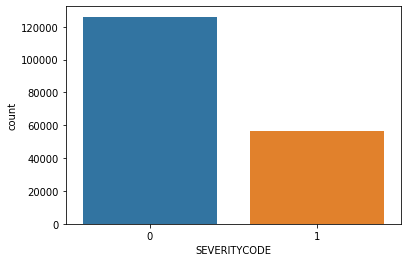

In [27]:
sns.countplot(inputDF['SEVERITYCODE'],label="Count")

### lets make our dataframe understandable for ml algorithm

In [28]:
# label_encoder object knows how to understand word labels. 
inputDF1 = inputDF.copy()
label_encoder = preprocessing.LabelEncoder()
# Encode labels in column 'LOCATION'. 
inputDF1['LOCATION']= label_encoder.fit_transform(inputDF1['LOCATION']) 

In [29]:
inputDF1["LOCATION"].value_counts().sort_values(ascending=False).head(10)

10626    272
10627    267
16568    259
10463    246
9001     241
10178    235
10467    232
19008    227
23328    207
10190    206
Name: LOCATION, dtype: int64

In [30]:
#topLocs = [ x for x in inputDF1.LOCATION.value_counts().sort_values(ascending=False).head(60).index]

In [31]:
inputDF1.columns
inputDF1.drop(["INCDTTM","timeType","ST_COLCODE","day","LOCATION"],inplace=True,axis=1)

In [32]:
#droping few more columns
#inputDF2 = inputDF1.drop(["LOCATION","SDOT_COLCODE","ST_COLCODE"],axis=1)
inputDF2 = inputDF1.copy()

In [34]:
#plotting correlation matrix

rs = np.random.RandomState(0)
corr = inputDF2.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(1)

,SEVERITYCODE,ADDRTYPE,PERSONCOUNT,VEHCOUNT,SDOT_COLCODE,INATTENTIONIND,UNDERINFL,PEDROWNOTGRNT,SPEEDING,HITPARKEDCAR
SEVERITYCODE,1,0.2,0.1,-0.08,0.2,0.04,0.04,0.2,0.04,-0.09
ADDRTYPE,0.2,1,0.06,-0.09,-0.07,-0.08,-0.05,0.2,-0.06,-0.1
PERSONCOUNT,0.1,0.06,1,0.4,-0.2,0.07,0.02,-0.03,-0.007,-0.05
VEHCOUNT,-0.08,-0.09,0.4,1,-0.5,0.05,-0.01,-0.3,-0.05,0.07
SDOT_COLCODE,0.2,-0.07,-0.2,-0.5,1,0.01,0.1,0.3,0.1,-0.07
INATTENTIONIND,0.04,-0.08,0.07,0.05,0.01,1,-0.03,-0.03,-0.05,0.02
UNDERINFL,0.04,-0.05,0.02,-0.01,0.1,-0.03,1,-0.02,0.09,0.02
PEDROWNOTGRNT,0.2,0.2,-0.03,-0.3,0.3,-0.03,-0.02,1,-0.03,-0.03
SPEEDING,0.04,-0.06,-0.007,-0.05,0.1,-0.05,0.09,-0.03,1,-0.02
HITPARKEDCAR,-0.09,-0.1,-0.05,0.07,-0.07,0.02,0.02,-0.03,-0.02,1


# Distribution analysis for feature variables

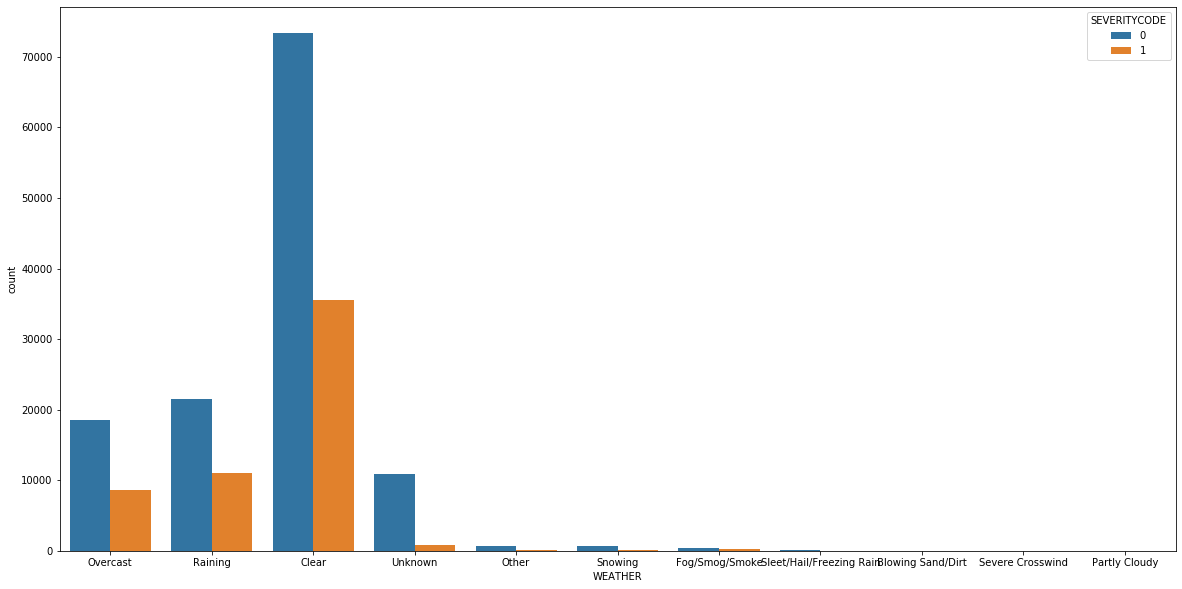

In [36]:
figsize=(20,10)
fig, ax = plt.subplots(figsize=figsize)
ax = sns.countplot(x="WEATHER", hue="SEVERITYCODE", data=inputDF2)

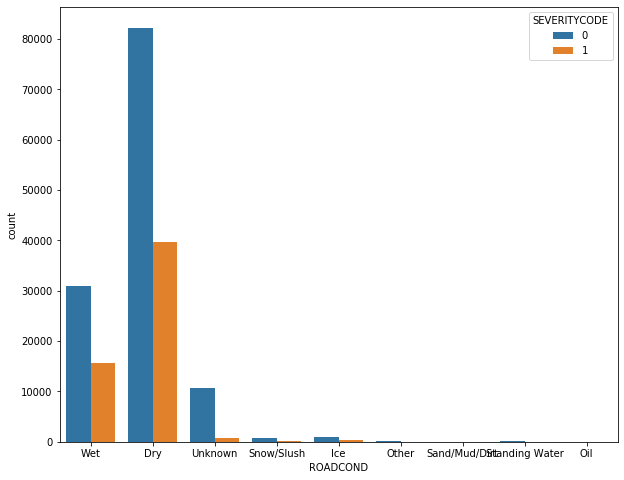

In [37]:
figsize=(10,8)
fig, ax = plt.subplots(figsize=figsize)
ax = sns.countplot(x="ROADCOND", hue="SEVERITYCODE", data=inputDF2)

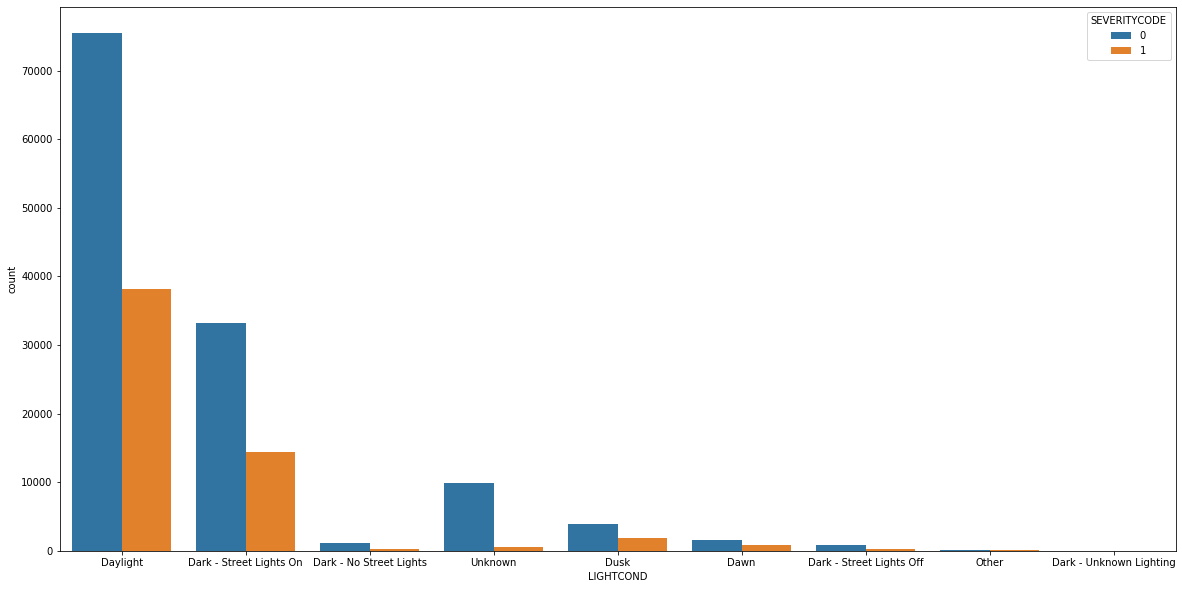

In [38]:
figsize=(20,10)
fig, ax = plt.subplots(figsize=figsize)
ax = sns.countplot(x="LIGHTCOND", hue="SEVERITYCODE", data=inputDF2)

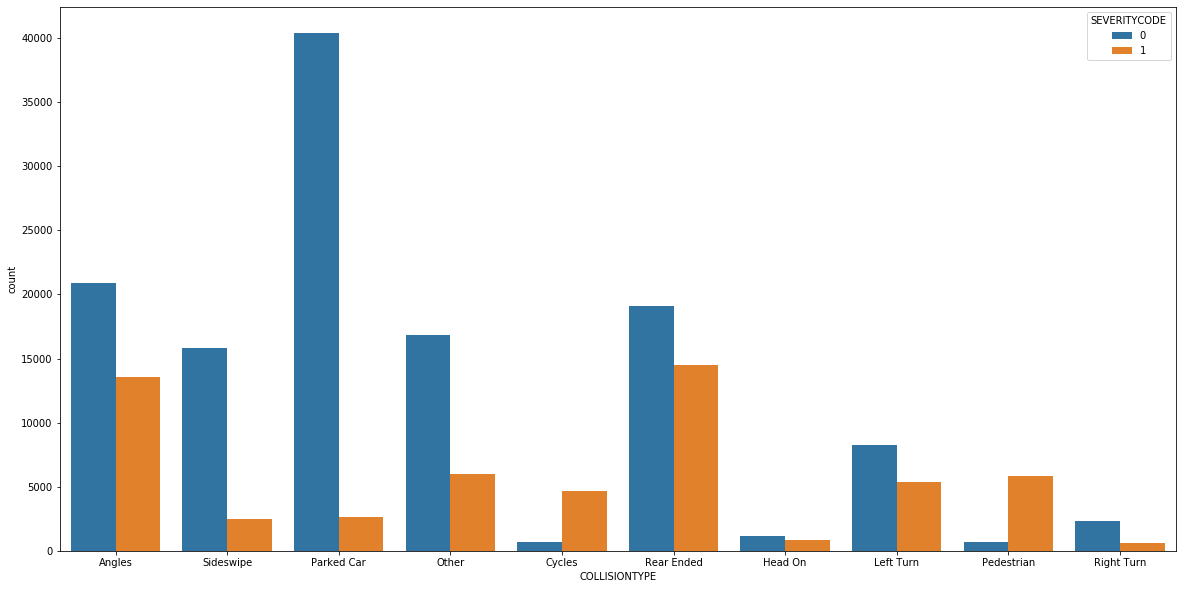

In [39]:
figsize=(20,10)
fig, ax = plt.subplots(figsize=figsize)
ax = sns.countplot(x="COLLISIONTYPE", hue="SEVERITYCODE", data=inputDF2)

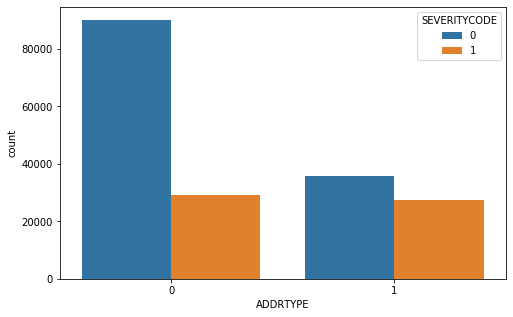

In [40]:
figsize=(8,5)
fig, ax = plt.subplots(figsize=figsize)
ax = sns.countplot(x="ADDRTYPE", hue="SEVERITYCODE", data=inputDF2)

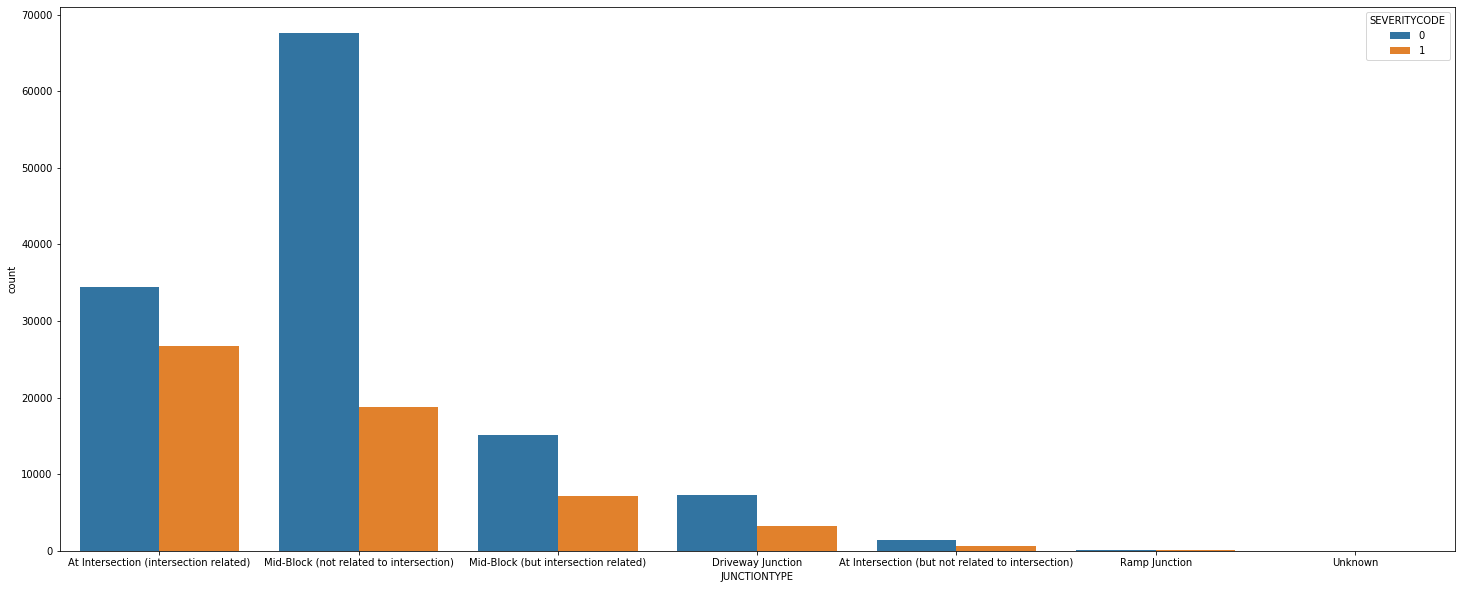

In [41]:
figsize=(25,10)
fig, ax = plt.subplots(figsize=figsize)
ax = sns.countplot(x="JUNCTIONTYPE", hue="SEVERITYCODE", data=inputDF2)

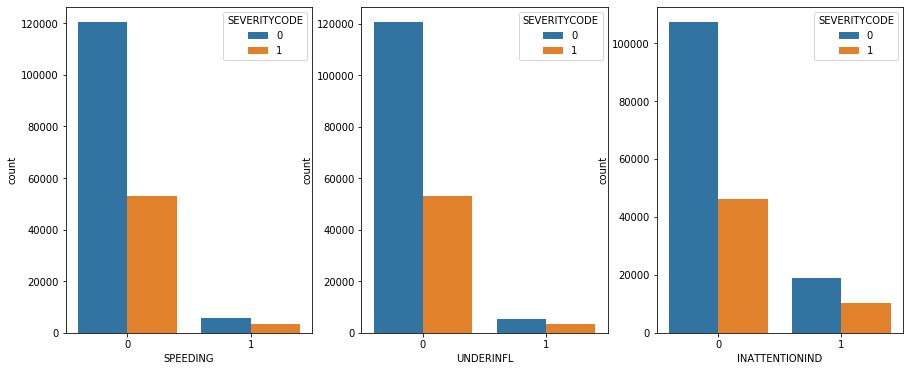

In [42]:
figsize=(15,6)
fig, ax = plt.subplots(figsize=figsize,ncols=3)
sns.countplot(x="SPEEDING", hue="SEVERITYCODE", data=inputDF2,ax=ax[0])
sns.countplot(x="UNDERINFL", hue="SEVERITYCODE", data=inputDF2,ax=ax[1])
sns.countplot(x="INATTENTIONIND", hue="SEVERITYCODE", data=inputDF2,ax=ax[2])

In [43]:
inputDF2["JUNCTIONTYPE"].value_counts()

Mid-Block (not related to intersection)              86434
At Intersection (intersection related)               61206
Mid-Block (but intersection related)                 22341
Driveway Junction                                    10460
At Intersection (but not related to intersection)     2054
Ramp Junction                                          160
Unknown                                                  5
Name: JUNCTIONTYPE, dtype: int64

## after analysis, multi categorical features does include some noise.

In [44]:
inputDF2["WEATHER"]= inputDF2["WEATHER"].apply(lambda x: "OVERCAST" if x == "Overcast" else ("RAINING" if x == "Raining" else
                                                                ("CLEAR" if x == "Clear" else ("UNKNOWN" if x =="Unknown" else
                                                                                              "UNRELATED" ))))

In [45]:
inputDF2["ROADCOND"]= inputDF2["ROADCOND"].apply(lambda x: "DRY" if x == "Dry" else ("WET" if x == "Wet" else
                                                                 ("UNKNOWN" if x =="Unknown" else
                                                                                              "UNRELATED" )))

In [46]:
inputDF2["LIGHTCOND"]= inputDF2["LIGHTCOND"].apply(lambda x: "DAYLIGHT" if x == "Daylight" else ("DARK-STREET-LIGHTS-ON" if x == "Dark - Street Lights On" else
                                                                ("UNKNOWN" if x == "Unknown" else ("DUSK" if x =="Dusk" else
                                                                                              "UNRELATED" ))))

In [47]:
inputDF2["JUNCTIONTYPE"]= inputDF2["JUNCTIONTYPE"].apply(lambda x: "MID-BLOCK-UNRELATED" if x == "Mid-Block (not related to intersection)" else ("INTERSECTION-RELATED" if x == "At Intersection (intersection related)" else
                                                                ("MID-BLOCK-RELATED" if x == "Mid-Block (but intersection related)" else ("DRIVEWAY" if x =="Driveway Junction" else
                                                                                              "UNRELATED" ))))

In [48]:
inputDF2.columns

Index(['SEVERITYCODE', 'ADDRTYPE', 'COLLISIONTYPE', 'PERSONCOUNT', 'VEHCOUNT',
       'JUNCTIONTYPE', 'SDOT_COLCODE', 'INATTENTIONIND', 'UNDERINFL',
       'WEATHER', 'ROADCOND', 'LIGHTCOND', 'PEDROWNOTGRNT', 'SPEEDING',
       'HITPARKEDCAR'],
      dtype='object')

## one hot encoding for categorical features

In [49]:
#ONE HOT ENCODING
inputDF2 = pd.get_dummies(inputDF2,columns=['WEATHER','ROADCOND','LIGHTCOND','COLLISIONTYPE','JUNCTIONTYPE'])

In [50]:
#remove the unrelated ones
inputDF2.drop(columns=["JUNCTIONTYPE_UNRELATED","LIGHTCOND_UNRELATED","ROADCOND_UNRELATED","WEATHER_UNRELATED"],axis=1,inplace=True)

### we have slightly imbalanced data, few records for severity "2", model can be biased

In [51]:
#split data into train and test
X = inputDF2.loc[:, inputDF2.columns != 'SEVERITYCODE']
y = inputDF2["SEVERITYCODE"]

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

# Decision Tree Classification

In [123]:
def get_best_decisionTree(X_train, X_test,y_train, y_test):
    accuracyDict={}
    for i in range(3,20):
        decisionTreeModel = DecisionTreeClassifier(max_depth=i)
        decisionTreeModel = decisionTreeModel.fit(X_train,y_train)
        y_pred = decisionTreeModel.predict(X_test)
        accuracyDict[i]=metrics.accuracy_score(y_test,y_pred)
        #accuracyDict[i]=metrics.f1_score(y_test,y_pred)
    best_n = max(accuracyDict, key= lambda x: accuracyDict[x])
    print("optimum max depth is",best_n)
    print("accuracy on test data is", accuracyDict[best_n])
    return DecisionTreeClassifier(max_depth=best_n).fit(X_train,y_train)
        
        
    

In [124]:
bestDecisionTreeModel = get_best_decisionTree(X_train, X_test,y_train, y_test)

optimum max depth is 9
accuracy on test data is 0.7476458994853826


In [125]:
#f1_score

y_pred = bestDecisionTreeModel.predict(X_test)
decisionTreeF1=metrics.f1_score(y_test,y_pred)
decisionTreeAcc = metrics.accuracy_score(y_test,y_pred)


In [126]:
print(decisionTreeF1)

0.44138683476785057


In [127]:
def get_confusion_matrix(cm,labels=[1,0]):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

In [128]:
cm_decisionTree=metrics.confusion_matrix(y_test,y_pred,labels=[1,0])

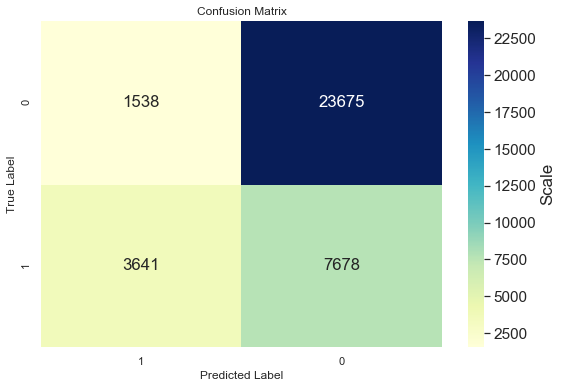

In [142]:
plot_confusion_matrix(cm_decisionTree,[1,0])

# KNN Classifier

In [66]:
def get_best_KNN(X_train, X_test,y_train, y_test):
    accuracyDict={}
    for i in range(3,20):
        knnModel = KNeighborsClassifier(n_neighbors=i)
        knnModel =knnModel.fit(X_train,y_train)
        y_pred = knnModel.predict(X_test)
        accuracyDict[i]=metrics.accuracy_score(y_test,y_pred)
        #accuracyDict[i]=metrics.f1_score(y_test,y_pred)
    best_n = max(accuracyDict, key= lambda x: accuracyDict[x])
    print("optimum max depth is",best_n)
    print("accuracy on test data is", accuracyDict[best_n])
    return KNeighborsClassifier(n_neighbors=best_n).fit(X_train,y_train)

In [212]:
bestKNNModel = get_best_KNN(X_train, X_test,y_train, y_test)

optimum max depth is 10
accuracy on test data is 0.7392423081134348


In [213]:
#f1_score
y_pred = bestKNNModel.predict(X_test)
metrics.f1_score(y_test,y_pred)

0.4612600384571881

In [232]:
labels=[1,0]
knn_confusion=metrics.confusion_matrix(y_test,y_pred,labels=[1,0])

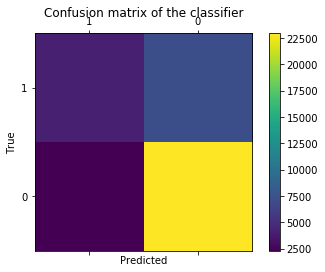

In [237]:
get_confusion_matrix(knn_confusion)

In [ ]:
# from sklearn.svm import SVC
# svclassifier = SVC(kernel='poly')
# svclassifier.fit(X_train, y_train)

e:\pycharmprojects\myprojects\venv\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [73]:
lrModel = LogisticRegression()
lrModel.fit(X_train,y_train)
y_pred=lrModel.predict(X_test)

e:\pycharmprojects\myprojects\venv\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [70]:
metrics.accuracy_score(y_test,y_pred)

0.7470436877258294

In [71]:
metrics.f1_score(y_test,y_pred)

0.41796309126409276

In [74]:
#log loss
y_pred_prob = lrModel.predict_proba(X_test)
metrics.log_loss(y_test,y_pred_prob)

0.4926479478447402

# All classifiers give almost same accuracy, the issue is it is not at all predicting sevee accidents accurately

# it is clear none of our model is working as f1_score is very less. Let's see if xgboost can save us

In [75]:
xgbModel = XGBClassifier()

In [76]:
hyperParams = {
    "learning_rate":[0.05,0.10,0.15,0.20,0.25,0.30],
    "max_depth" : [3,4,5,6,8,10,12,15,20],
    "min_child_weight": [1,3,5,7],
    "gamma":[0.1,0.2,0.3,0.4],
    "colsample_bytree":[0.3,0.4,0.5,0.7],
    "scale_pos_weight":[2,2.2,2.5,2.7,2.9,3]
}

In [79]:
random_search = RandomizedSearchCV(xgbModel,param_distributions=hyperParams,n_iter=5,n_jobs=-1,cv=5,verbose=3,scoring='f1')

In [80]:
weight = int(y_train.value_counts()[0]/y_train.value_counts()[1])
print(weight)

2


In [81]:
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  19 out of  25 | elapsed:  2.5min remaining:   47.3s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  2.7min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_co...
                   iid='warn', n_iter=5, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.3, 0.4, 0.5,
                                                             0.7],
                             

In [82]:
random_search.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4, gamma=0.4, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.3, max_delta_step=0, max_depth=4,
              min_child_weight=5, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=2.7, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [143]:
bestXGBoost=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4, gamma=0.4, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.3, max_delta_step=0, max_depth=4,
              min_child_weight=5, missing=np.nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=2.7, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [144]:
bestXGBoost.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4, gamma=0.4, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.3, max_delta_step=0, max_depth=4,
              min_child_weight=5, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=2.7, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [145]:
y_pred = bestXGBoost.predict(X_test)

In [146]:
metrics.accuracy_score(y_test,y_pred)

0.6600788349939779

In [147]:
metrics.f1_score(y_test,y_pred)

0.606577113166899

In [148]:
xgb_cm=metrics.confusion_matrix(y_test,y_pred,labels=[1,0])

In [149]:
print(metrics.classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.89      0.58      0.70     25213
           1       0.47      0.85      0.61     11319

    accuracy                           0.66     36532
   macro avg       0.68      0.71      0.65     36532
weighted avg       0.76      0.66      0.67     36532



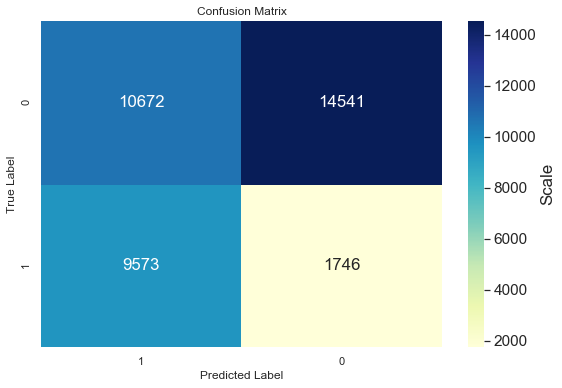

In [150]:
plot_confusion_matrix(xgb_cm,[1,0])

In [151]:
# xg boos without weights
bestXGBoost=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4, gamma=0.4, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.3, max_delta_step=0, max_depth=4,
              min_child_weight=5, missing=np.nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [152]:
bestXGBoost.fit(X_train, y_train)
y_pred = bestXGBoost.predict(X_test)
metrics.accuracy_score(y_test,y_pred)

0.7512044235191065

In [153]:
metrics.f1_score(y_test,y_pred)

0.4495851753164174

In [154]:
xgb_without_weight_cm=metrics.confusion_matrix(y_test,y_pred,labels=[1,0])

In [155]:
print(metrics.classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.76      0.94      0.84     25213
           1       0.71      0.33      0.45     11319

    accuracy                           0.75     36532
   macro avg       0.74      0.63      0.64     36532
weighted avg       0.74      0.75      0.72     36532



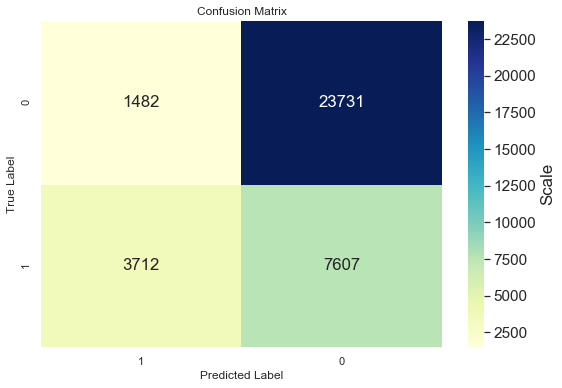

In [156]:
plot_confusion_matrix(xgb_without_weight_cm,[1,0])

### wow the f1_score has jumped soooo much using the weight parameter
### also now predicting severe accidents is much better, which is actually important.
### our goal is to maximise the prediction for accident with severity dangerous(2). Xgboost is giving it around 84%